In [1]:
#Section 0: imports and setup
import random
import sys

import xarray
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

sys.path.append("../")
from ccdown import correction_downscale_methods, distribution_tests, error_metrics, som_downscale, utilities, \
    train_test_splits, climdex, plotters
# for reproducibility
seed = 1
random.seed(seed)

In [2]:
#Section 1: loading and organizing the data
#define the inputs
downscaling_target='precip'
station_id='725300-94846' 
input_vars = {'air': 850, 'rhum': 850, 'uwnd': 700, 'vwnd': 700, 'hgt': 500, 'slp':'surf'}
station_data = pd.read_csv('./data/stations/' + station_id + '.csv')
station_data = station_data.replace(to_replace=[99.99, 9999.9], value=np.nan)

reanalysis_data_pres = xarray.open_mfdataset('./data/models/pres_level/*NCEP*')
reanalysis_data_surf = xarray.open_mfdataset('./data/models/surface/slp*NCEP*')
reanalysis_data = xarray.merge([reanalysis_data_surf, reanalysis_data_pres])

stations_info = pd.read_csv('./data/stations/stations.csv')
station_info = stations_info.loc[stations_info['stationID'] == station_id]
station_lat = station_info['LAT'].values
station_lon = station_info['LON'].values
# load the reanalysis precipitation
if downscaling_target == 'precip':
    rean_precip = xarray.open_mfdataset('./data/reanalysis/prate_1976-2005_NCEP_midwest.nc')
    # convert from Kg/m^2/s to mm/day
    rean_precip['prate'] = rean_precip['prate'] * 86400
    rean_precip = rean_precip['prate'].sel(lat=station_lat, lon=station_lon, method='nearest').values
    rean_precip = np.squeeze(rean_precip)
elif downscaling_target == 'max_temp':
    rean_precip = xarray.open_mfdataset('./data/models/air_1976-2005_NCEP_midwest.nc')
    rean_precip = rean_precip['air'].sel(level=1000, lat=station_lat, lon=station_lon, method='nearest').values
    # convert K to C
    rean_precip = rean_precip - 273.15
    rean_precip = np.squeeze(rean_precip)

# select the station data to match the time from of the reanalysis data
start = reanalysis_data['time'][0].values
end = reanalysis_data['time'][-1].values
station_data['time'] = pd.to_datetime(station_data['date'], format='%Y-%m-%d')
date_mask = ((station_data['time'] >= start) & (station_data['time'] <= end))
station_data = station_data[date_mask]

hist_data = station_data[downscaling_target].values
# Convert units, F to C for temperature, in/day to mm/day for precip
if downscaling_target == 'max_temp':
    hist_data = (hist_data - 32) * 5 / 9
if downscaling_target == 'precip':
    hist_data = hist_data * 25.4
# For just a single grid point:
# reanalysis_data = reanalysis_data.sel(lat = station_lat, lon = station_lon, method='nearest')
# To use multiple grid points in a window around the location:
window = 2
lat_index = np.argmin(np.abs(reanalysis_data['lat'].values - station_lat))
lon_index = np.argmin(np.abs(reanalysis_data['lon'].values - station_lon))
reanalysis_data = reanalysis_data.isel({'lat': slice(lat_index - window, lat_index + window + 1),
                                        'lon': slice(lon_index - window, lon_index + window + 1)})

# Drop leap days for ease of use:
hist_data = utilities.remove_leap_days(hist_data, start_year=1976)
rean_precip = utilities.remove_leap_days(rean_precip, start_year=1976)
reanalysis_data = utilities.remove_xarray_leap_days(reanalysis_data)

# split train and test sets:
dates = reanalysis_data['time']
hist_data = xarray.DataArray(data=hist_data, dims=['time'], coords={'time': dates})
rean_precip = xarray.DataArray(data=rean_precip, dims=['time'], coords={'time': dates})

In [3]:
#Section 2: Splitting the train and test sets
#This section has three options for splitting the data: simple, seasonal, and pecentile
split_type = 'simple'
dates = reanalysis_data['time']
hist_data = xarray.DataArray(data=hist_data, dims=['time'], coords={'time': dates})
rean_precip = xarray.DataArray(data=rean_precip, dims=['time'], coords={'time': dates})

# with a simple split:
if split_type == 'simple':
    train_data, train_hist, test_data, test_hist, rean_precip_train, rean_precip_test = train_test_splits.simple_split(
    reanalysis_data, hist_data, rean_precip)

# selecting the highest precip/temperature years:
elif split_type == 'percentile':
    train_data, test_data, train_hist, test_hist, rean_precip_train, rean_precip_test = train_test_splits.select_max_target_years(
   reanalysis_data, hist_data, 'max', time_period='year', split=0.8, rean_data=rean_precip)

# training on the spring, testing on the summer:
elif split_type == 'seasonal':
    train_dates = utilities.generate_dates_list('3/1', '5/31', list(range(1976, 2006)))
    test_dates = utilities.generate_dates_list('6/1', '8/31', list(range(1976, 2006)))
    train_data, test_data, train_hist, test_hist, rean_precip_train, rean_precip_test = train_test_splits.select_season_train_test(
    	reanalysis_data, hist_data, train_dates, test_dates, rean_data=rean_precip)

In [5]:
#Section 3: normalize the data, and reorganize for use in the downscaling methods
input_train_data = []
input_test_data = []
for var in input_vars:
    if input_vars[var] == 'surf':
        var_data = train_data[var].values
        var_test_data = test_data[var].values
    else:
        var_data = train_data.sel(level=input_vars[var])[var].values
        var_test_data = test_data.sel(level=input_vars[var])[var].values

    var_data = var_data.reshape(var_data.shape[0], var_data.shape[1] * var_data.shape[2])
    input_train_data.append(var_data)
    var_test_data = var_test_data.reshape(var_test_data.shape[0], var_test_data.shape[1] * var_test_data.shape[2])
    input_test_data.append(var_test_data)
input_train_data = np.concatenate(input_train_data, axis=1)
input_train_data = np.array(input_train_data)
input_test_data = np.concatenate(input_test_data, axis=1)
input_test_data = np.array(input_test_data)

# normalize (z-score) the reanalysis data, for use in downscaling methods
train_data, input_means, input_stdevs = utilities.normalize_climate_data(input_train_data)
test_data, input_test_means, input_test_stdevs = utilities.normalize_climate_data(input_test_data,
                                                                                  means=input_means,
                                                                                  stdevs=input_stdevs)

hist, rean_precip_train = utilities.remove_missing(train_hist, rean_precip_train)
train_hist, train_data = utilities.remove_missing(train_hist, train_data)

In [6]:
#Section 4: initialize the different methods
som = som_downscale.som_downscale(som_x=7, som_y=5, batch=512, alpha=0.1, epochs=50)
rf_two_part = correction_downscale_methods.two_step_random_forest()
random_forest = sklearn.ensemble.RandomForestRegressor()
qmap = correction_downscale_methods.quantile_mapping()
linear = sklearn.linear_model.LinearRegression()

In [7]:
#Section 5: train and generate outputs
som.fit(train_data, train_hist, seed=1)
random_forest.fit(train_data, train_hist)
rf_two_part.fit(train_data, train_hist)
linear.fit(train_data, train_hist)
qmap.fit(rean_precip_train, train_hist)

# generate outputs from the test data
som_output = som.predict(test_data)
random_forest_output = random_forest.predict(test_data)
rf_two_part_output = rf_two_part.predict(test_data)
linear_output = linear.predict(test_data)
qmap_output = qmap.predict(rean_precip_test)

# generate outputs from the train data for comparision
som_train_output = som.predict(train_data)
random_forest_train_output = random_forest.predict(train_data)
rf_two_part_train_output = rf_two_part.predict(train_data)
linear_train_output = linear.predict(train_data)
qmap_train_output = qmap.predict(rean_precip_train)

# Include the reanalysis precipitation as an undownscaled comparison
names = ['SOM', 'Random Forest', 'RF Two Part', 'Linear', 'Qmap', 'NCEP']
outputs = [som_output, random_forest_output, rf_two_part_output, linear_output, qmap_output, rean_precip_test]

2023-04-11 11:54:20.372756: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2023-04-11 11:54:21.151744: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2023-04-11 11:54:21.197962: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5643d335e600 executing computations on platform Host. Devices:
2023-04-11 11:54:21.198001: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


2023-04-11 11:54:24.315149: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


time to train for 50 epochs:  18.72332191467285
(3353, 150) (3353,)


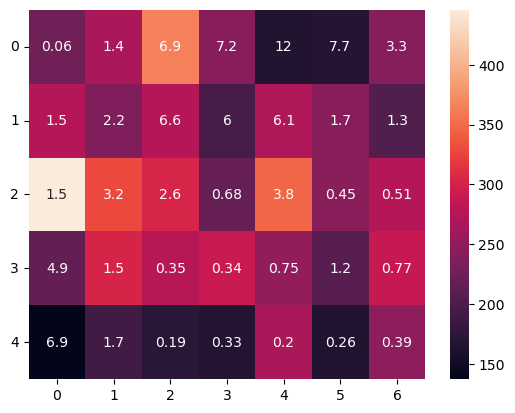

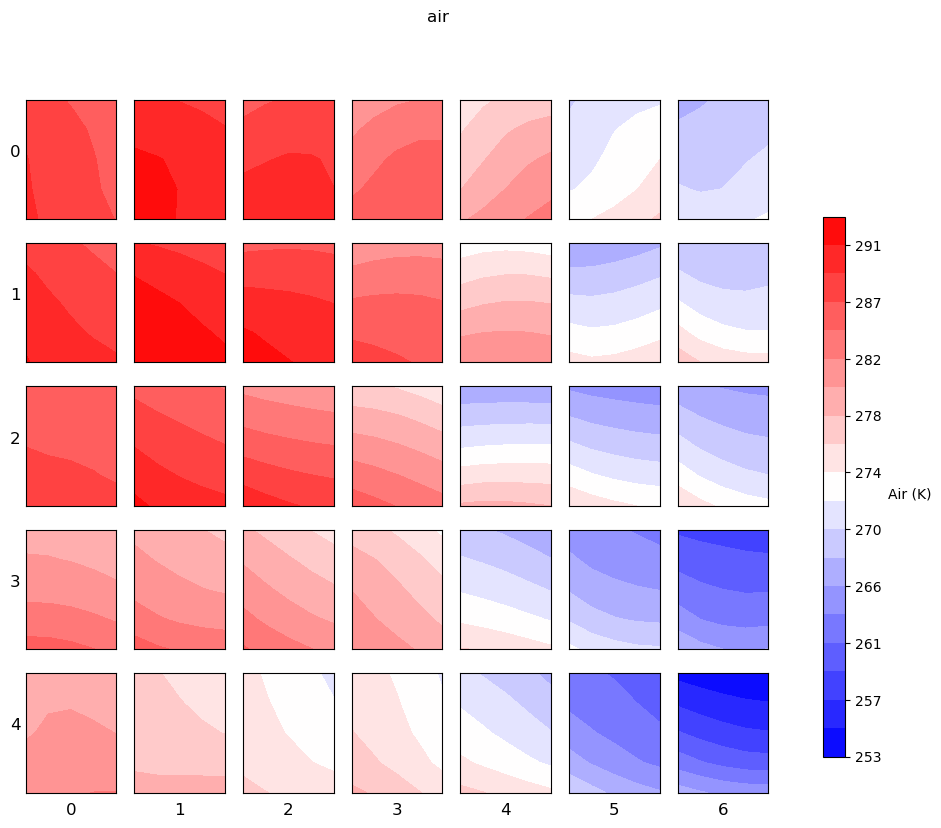

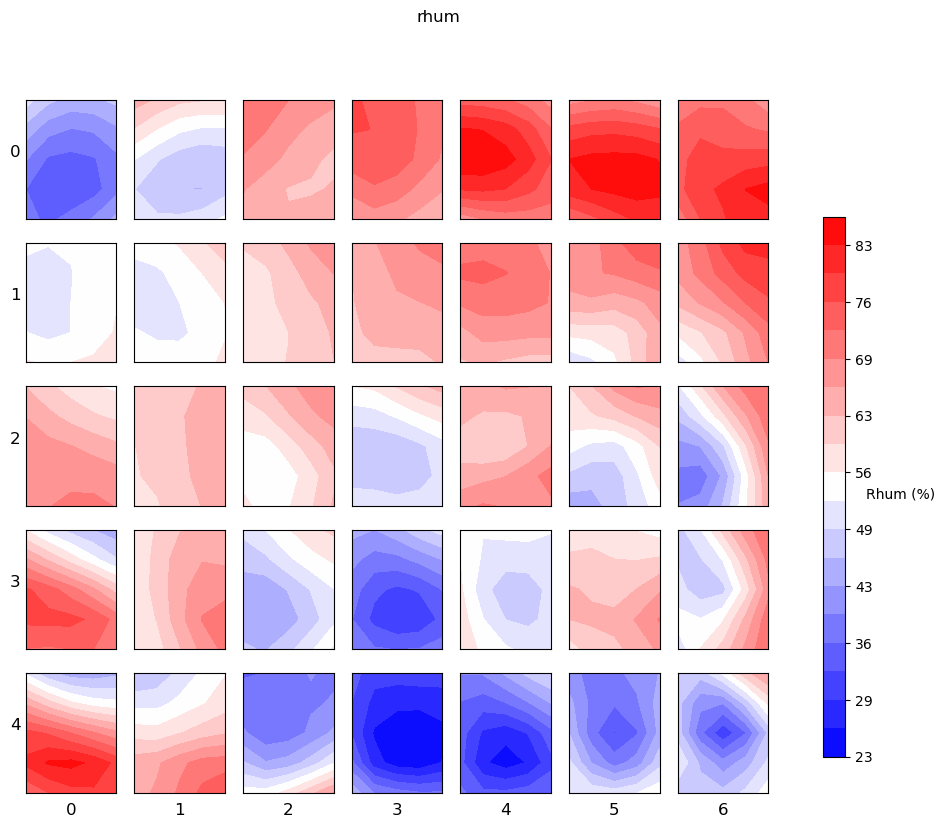

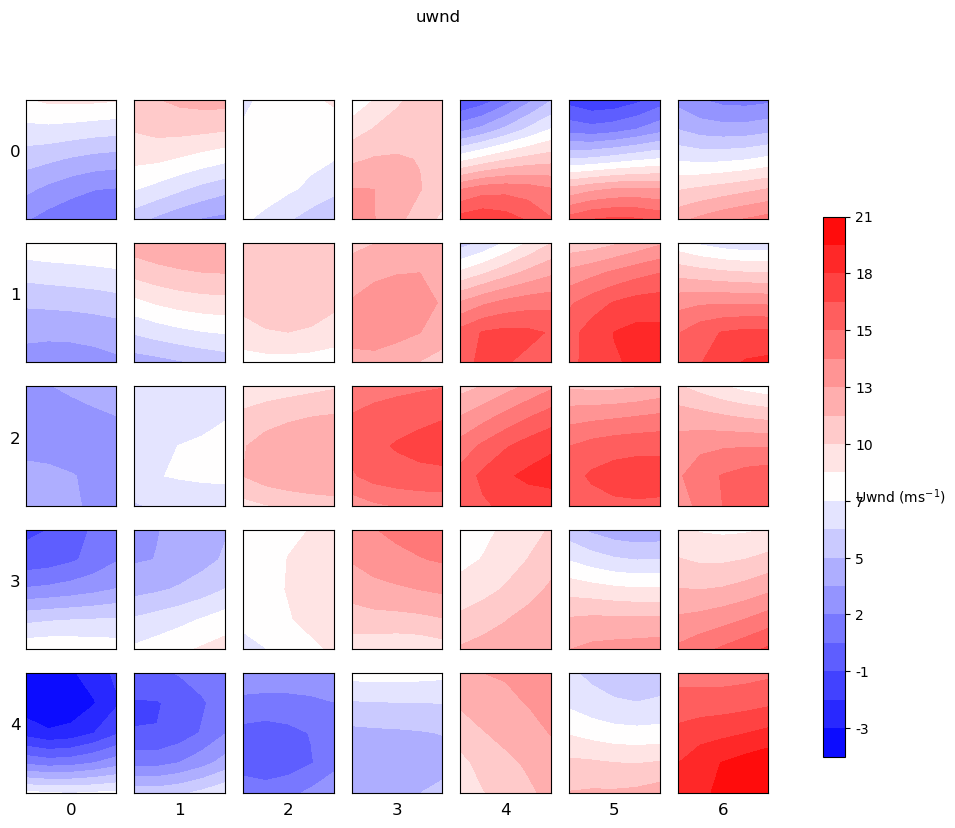

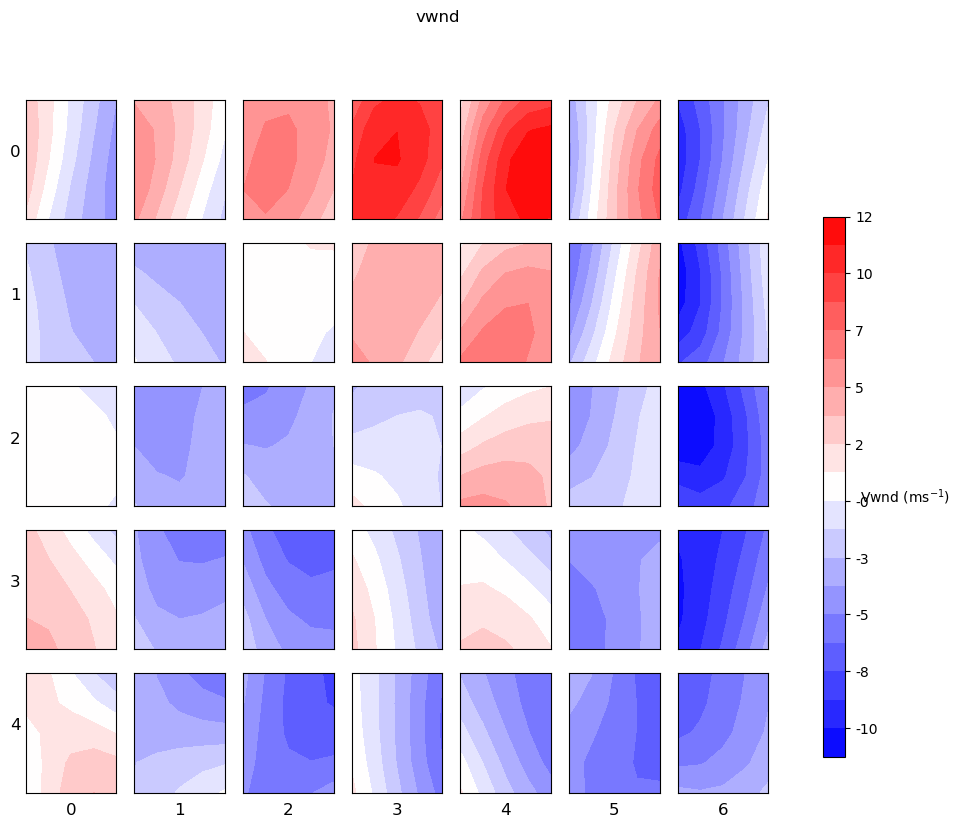

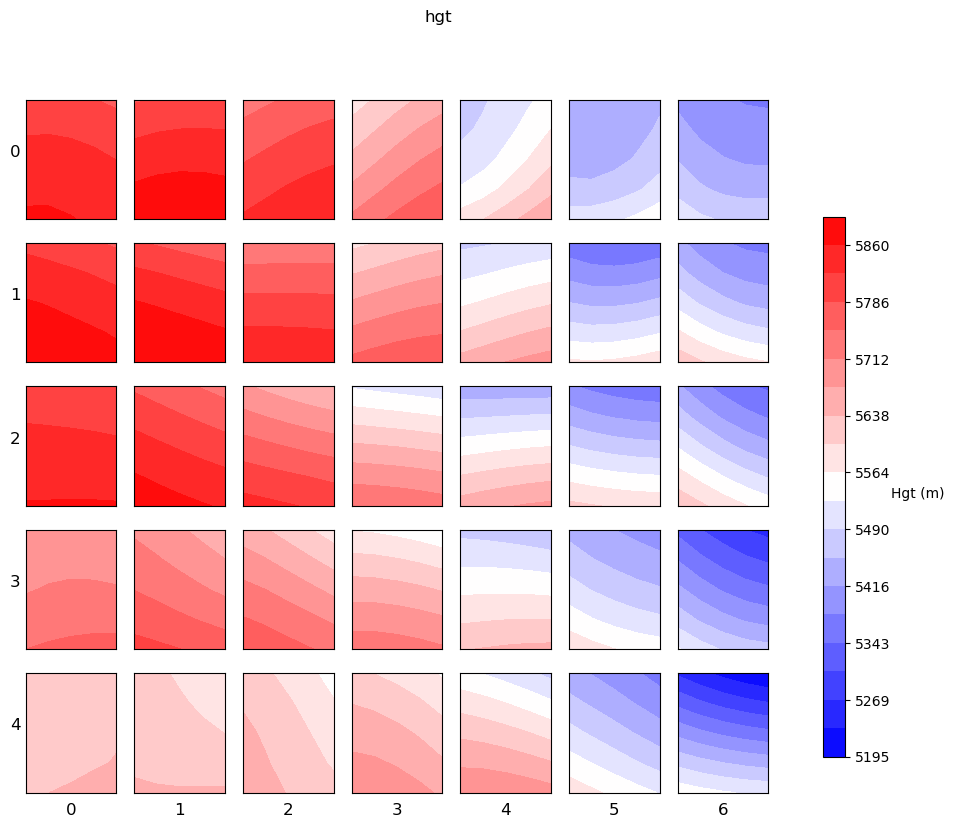

KeyError: 'slp'

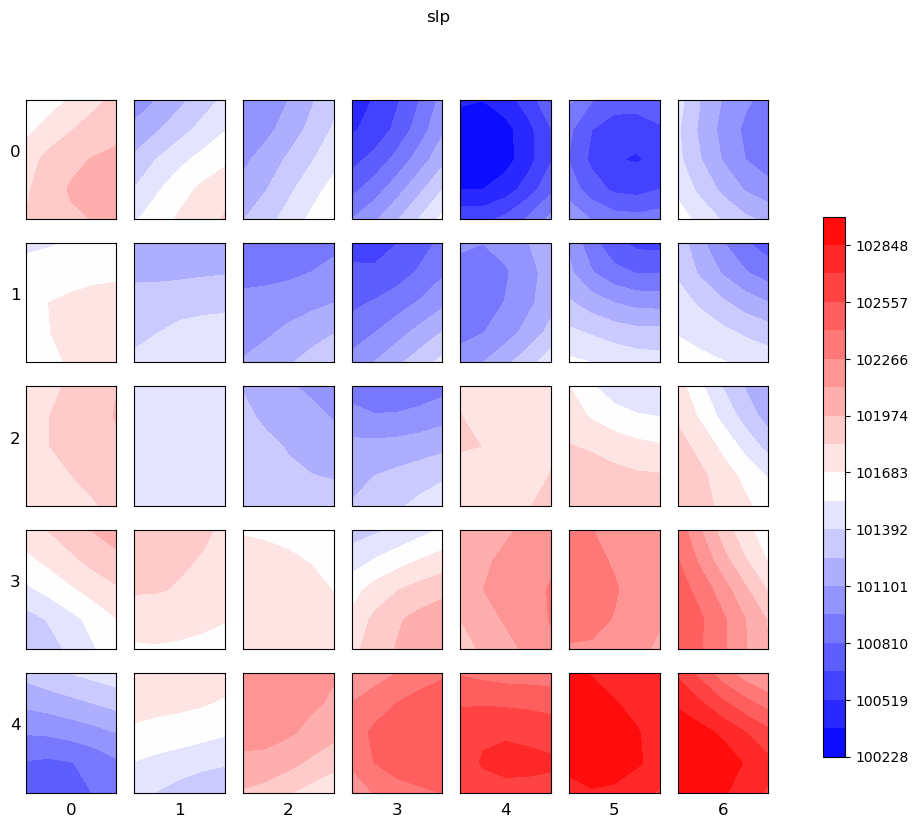

In [8]:
# Section 6: SOM specific analysis plots, heatmap and variable grids
freq, avg, dry = som.node_stats()
#The heatmap shows the frequency of each node of the SOM in the test set
ax = som.heat_map(train_data, annot=avg)
plt.yticks(rotation=0)
plt.show()
i = 0
index_range = (window * 2 + 1) ** 2
for var in input_vars:
    start_index = i * index_range
    end_index = (i + 1) * index_range
    fig, ax, cbar = som.plot_nodes(weights_index=(start_index, end_index), means=input_means[start_index:end_index],
                                   stdevs=input_stdevs[start_index:end_index], cmap='bwr')
    for axis in ax.flatten():
        axis.set_xticks([])
        axis.set_yticks([])

    for axis, col in zip(ax[-1], range(0, som.som_x)):
        axis.set_xlabel(col, size='large')
    for axis, row in zip(ax[:, 0], range(0, som.som_y)):
        axis.set_ylabel(row, rotation=0, size='large')
    #The variable plots show the value of the variable in each of the SOM nodes 
    fig.suptitle(var)
    units = {'air': '(K)', 'rhum': '(%)', 'uwnd': r'(ms$^{-1}$)', 'vwnd': r'(ms$^{-1}$)', 'hgt': '(m)', 'slp':'(hPa)'}
    cbar.set_label(var.capitalize() + ' ' + units[var], rotation='horizontal', labelpad=20)
    plt.show()
    i += 1

In [9]:
#Section 7: Skill metric scores for each method
scores = {}
np.set_printoptions(precision=2, suppress=True)
i = 0
for output in outputs:
    noNan_test_hist, noNan_output = utilities.remove_missing(test_hist, output)
    pdf_score = distribution_tests.pdf_skill_score(noNan_output, noNan_test_hist)
    ks_stat, ks_probs = distribution_tests.ks_testing(noNan_output, noNan_test_hist)
    rmse = sklearn.metrics.mean_squared_error(noNan_test_hist, noNan_output, squared=False)
    bias = error_metrics.calc_bias(noNan_output, noNan_test_hist)

    print(names[i], round(pdf_score, 3), round(ks_stat, 2), round(rmse, 2), round(bias, 2))
    scores[names[i]] = [round(pdf_score, 3), round(ks_stat, 2), round(rmse, 2), round(bias, 2)]
    i += 1

SOM 0.994 0.05 10.13 -0.09
Random Forest 0.973 0.64 8.6 -0.55
RF Two Part 0.973 0.09 8.51 0.36
Linear 0.946 0.44 8.43 -0.35
Qmap 0.995 0.17 9.91 -0.2
NCEP 0.986 0.65 8.78 0.1


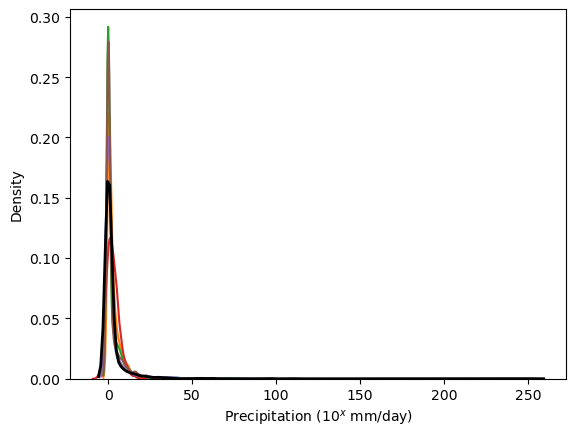

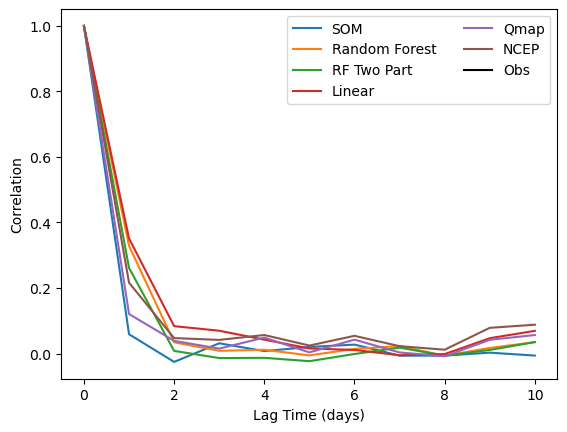

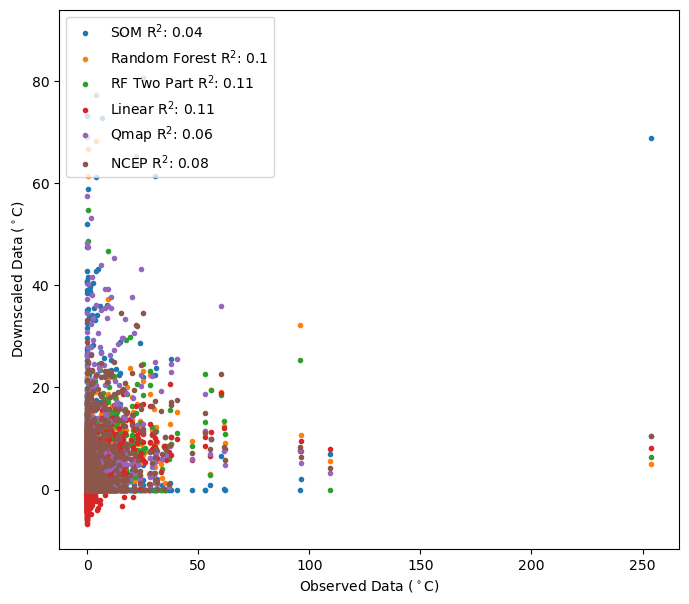

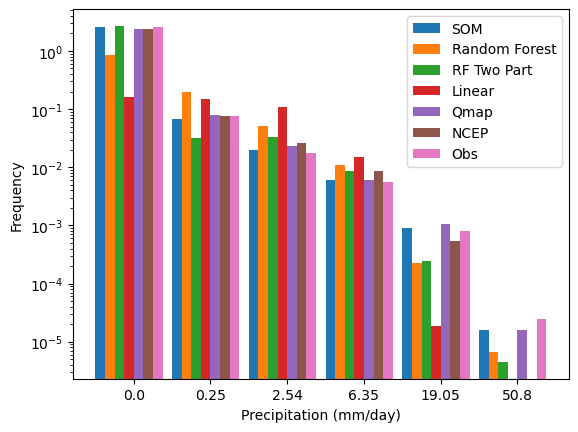

In [11]:
#Section 8: Plots comparing the outputs: KDE, autocorrelation, and histogram
fig, ax = plotters.plot_kde(outputs, names, test_hist, scores, downscaling_target)
plt.show()

fig, ax = plotters.plot_autocorrelation(outputs, names, test_hist)
plt.show()

fig, ax = plotters.scatter_plot(outputs, names, test_hist)
plt.show()

fig, ax = plotters.plot_bargraph(outputs, names, test_hist)
plt.show()

In [12]:
#Section 9: Climdex values for each output
#Note that the climdex values assume the outputs are a given number of full years, so some of the results will not make sense for seasonal models
for i in range(len(outputs)):
    climdex_values, func_list = climdex.calc_climdex(outputs[i], downscaling_target, reference_data = train_hist)
    print()
    print(names[i])
    climdex.print_indices(climdex_values, func_list)

ValueError: cannot reshape array of size 2189 into shape (365)